In [ ]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross testing of methods

In [34]:
#X, true_y = load_wine(return_X_y=True)
X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

X = StandardScaler().fit_transform(X)
cf_amount = 25

nc = 2
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float

cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    cfs.append(CounterfactualData([], index, target, label))

## Baseline

In [169]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 6 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (775) CFs (5)
Re-training surrogate model with data size: 775
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (225) Unique overall (225)
Generated random instances: (3738)
Predicted top: 20 Counterfactuals: 17
Found new best [ 1.17090767  0.16064943  1.13812505  1.09529491 -0.18675805  0.08829524
 -0.98622238 -0.99147281 -0.06432462 -0.76233215  0.40393845 -0.80493989
  0.15541029  0.29862746 -0.90902983 -0.65156801 -0.31014139 -0.22808903
  0.70316341  0.12176289  1.3689833   0.32288289  1.3683253  -0.91472531
  0.51864023  0.02121498  0.50955225  1.1967158   0.26247566 -0.01473048], with fitness score 0.7163 (X 0.93424 Y 1.0 F 0.76667), oversampling
Known alternatives: 795
Best instance score 0.7163 (X 0.9

## Baycon

In [170]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 6 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (774) CFs (648)
Re-training surrogate model with data size: 774
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (182) Unique overall (182)
Generated random instances: (3726)
Predicted top: 20 Counterfactuals: 20
Known alternatives: 794
Best instance score 0.2652 (X 0.961 Y 0.36 F 0.76667), found on epoch: 0
Re-training surrogate model with data size: 794
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (138) Unique overall (301)
Generated random instances: (3710)
Predicted top: 20 Counterfactuals: 20
Found new best [ 0.25099584  0.16064943 -0.27923496  1.09529491 -1.27617998  1.7833797
  0.3000724  -0.80557166 -0.06432462 -0.62839553  1.21181536 -0.80493989
  0.15541029 -0.43659313 -0.90902983 -0.65156801 -

## CFDE

In [171]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([ 1.17090767, -0.24146282,  1.13812505,  1.09529491, -0.30323779,
        -0.51845754, -0.57576937,  0.64693511, -0.3063744 , -0.76210515,
        -0.42683029, -0.80493989, -0.42965177, -0.40249446, -0.90902983,
        -0.35496386, -0.32401226, -0.38908298, -0.83077873, -0.21288464,
         1.3689833 ,  0.08117995,  1.3683253 ,  1.27521954,  0.0743949 ,
        -0.48855609, -0.30055694,  1.1967158 , -0.30375616, -0.32309887]), array([ 1.17090767, -0.24146282,  1.13812505,  1.09529491, -0.30323779,
        -0.51845754, -0.50202798,  0.64693511, -0.3063744 , -0.76287308,
        -0.42683029, -0.80493989, -0.42965177, -0.40249446, -0.90902983,
        -0.35496386, -0.32401226, -0.38908298, -0.70173678, -0.21288464,
         1.3689833 , -0.00808263,  1.3683253 ,  1.27521954,  0.01852443,
        -0.48855609, -0.3250249 ,  1.1967158 , -0.30375616, -0.32309887]), array([ 1.17090767, -0.24146282,  1.13812505,  1.09529491, -0.30323779,
        -0.42713678, -0.57

## CFAE

In [172]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([ 1.17090767,  0.16064943,  1.13812505,  1.09529491, -0.12313623,
         0.08829524,  0.3000724 ,  0.64693511, -0.06432462, -0.76233215,
         0.14988307, -0.80493989,  0.15541029,  0.29862746, -0.46668222,
        -0.65156801, -0.31014139, -0.22808903, -0.82966608, -0.61121781,
         0.14112956, -0.59430059,  0.16734316,  0.14879181,  0.51864023,
         0.02121498,  0.50955225, -0.15810961,  0.26247566, -0.01473048]), array([-0.10773728,  0.16064943,  1.13812505,  1.09529491, -0.12313623,
         0.08829524,  0.3000724 ,  0.64693511, -0.06432462, -0.76233215,
         0.14988307,  0.72761914,  0.15541029,  0.29862746, -0.02098691,
        -0.65156801, -0.31014139, -0.22808903, -0.82966608, -0.61121781,
         0.03481395,  0.32288289, -0.00450104,  1.27521954,  0.51864023,
         0.02121498,  0.50955225, -0.19676532,  0.26247566, -0.01473048]), array([ 0.27273723,  0.16064943,  0.24290925,  1.09529491, -0.12313623,
         0.08829524,  0.30

## NeighborSearch

In [173]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

ns_cfs

[CounterfactualData(cf=array([[ 1.18794852,  0.16064943,  1.09693485,  1.09813901, -0.74583384,
         -0.37260474,  0.3000724 ,  0.64693511, -0.69593783, -1.21171264,
         -0.53225762, -1.3447072 , -0.51931643, -0.25119526, -1.39171606,
         -0.65156801, -0.31014139, -0.82356071, -1.19290159, -1.02426827,
          1.3689833 ,  0.32288289,  0.95132356,  1.27521954, -0.39314631,
         -0.06211932,  0.50955225,  0.64703563,  0.49381829, -0.80717667],
        [ 0.44667147,  0.23744264,  0.38022536,  0.31771725, -0.02777453,
          0.08829524, -0.2871236 ,  0.07663016, -0.70689066, -1.03592974,
         -0.12730426, -0.12129511, -0.2277434 ,  0.29862746, -0.80502561,
         -0.15918117, -0.40961246, -0.32914565, -0.61414634, -0.51627672,
          0.79536469,  1.16315686,  0.65644376,  0.68280296,  0.39589973,
          0.63890664,  0.08641068,  0.60135584,  0.86752561,  0.13101312],
        [ 0.15697699,  0.19555543,  0.11413667,  0.08421643,  0.16437216,
          0.08

# Dice Mod

In [174]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist


dice_cfs = []
for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([
        # random_opt(instance, gainer.gain)[0][0] 
        adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]
    for _ in range(1)])
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_cfs

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 115, score: 0.8817529587993573
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 110, score: 0.7937632726029056
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 102, score: 0.8584278890210814
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 160, score: 0.8515250880202727
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 111, score: 0.8459307445397182
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 111, score: 0.8796131609824236
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 109, score: 0.9356207657383108
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 103, score: 0.8368971133864537
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 159, score: 0.9460995275126071
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 121, 

[CounterfactualData(cf=array([[-0.71678504,  0.16498435, -0.69117589, -0.505987  , -0.85781099,
         -0.38854698, -1.04772989, -0.00385077, -0.02942102, -0.23152914,
         -0.3358159 , -0.57644685, -0.35370346, -0.27162433,  0.19140405,
         -0.81191126, -0.83240353, -1.11002081, -0.43993378, -0.59360596,
          0.2850988 , -0.08997458,  0.27630916, -0.81310477,  0.53459032,
         -0.25576203, -0.88126912, -0.94068537, -0.17507372,  0.14085308]]), instance=6, target=1, instance_label=np.int32(0)),
 CounterfactualData(cf=array([[ 0.7281066 , -0.24201631,  0.7462725 ,  0.489564  ,  1.22970381,
         -0.05309853,  0.35555711,  0.42642292,  1.02401476,  0.93323642,
          0.2490923 ,  0.10244889,  0.2861318 ,  0.27764434,  0.84675408,
         -0.15388736,  0.14907619,  0.73515932,  0.14447563,  0.67562407,
          0.62958669, -0.65671613,  0.68424341,  0.46923095,  0.89115951,
          0.17356173,  0.46206255,  0.44119808,  0.3947578 ,  0.96696909]]), instance=10

# threshold tree / imm

In [175]:
from lib.threshold_tree import ThresholdTree

tt = ThresholdTree(km, centers, X, y)
tt_dtc_cfs = []
tt_dtc_prime_cfs = []
tt_imm_cfs = []
tt_imm_prime_cfs = []
print(centers)
for cf in cfs:
    tt_cf, tt_cf_prime = tt.find_counterfactuals_dtc(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)

    tt_imm_cf, tt_imm_cf_prime = tt.find_counterfactuals_imm(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_imm_prime_cfs.append(cf_data)



print(tt_dtc_cfs)
print(tt_dtc_prime_cfs)
print(tt_imm_cfs)
print(tt_imm_prime_cfs)

[[ 0.95696993  0.47041462  0.98955007  0.94479914  0.59076378  1.010052
   1.12170614  1.1414004   0.59687447  0.24841954  0.83154503  0.02368601
   0.83704179  0.78413429  0.00576374  0.69153581  0.63123632  0.75800622
   0.12574808  0.41473898  1.02206105  0.49306731  1.04941157  0.98350076
   0.59778105  0.95179839  1.04461284  1.13199171  0.59177365  0.62945686]
 [-0.49121063 -0.24146282 -0.50793395 -0.48496339 -0.30323779 -0.51845754
  -0.57576937 -0.5858784  -0.3063744  -0.12751322 -0.42683029 -0.01215798
  -0.42965177 -0.40249446 -0.00295852 -0.35496386 -0.32401226 -0.38908298
  -0.06454622 -0.21288464 -0.52462176 -0.2530904  -0.53866072 -0.50482885
  -0.30683974 -0.48855609 -0.53619755 -0.58104894 -0.30375616 -0.32309887]]
DTC accuracy: 0.9982425307557118

[ 0.          0.          0.          0.          0.          0.
  0.         -0.36927411  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.  

## Testing

In [ ]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}
nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}
dice_mod = {
    "name": "dice_mod",
    "counterfactuals": dice_cfs
}
tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
tt_dtc_prime = {
    "name": "ThresholdTree_DTC_Post_Proccesing",
    "counterfactuals": tt_dtc_prime_cfs
}
tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}
tt_imm_prime = {
    "name": "ThresholdTree_IMM_Post_Proccesing",
    "counterfactuals": tt_imm_prime_cfs
}

methods = [baseLine, Baycon, cfde, cfae, nfs, dice_mod, tt_dtc, tt_dtc_prime, tt_imm, tt_imm_prime]

with open('testdata/dummy.pickle', 'wb') as handle:
    pickle.dump(methods, handle, protocol=pickle.HIGHEST_PROTOCOL)

KeyboardInterrupt: 

In [ ]:
with open('testdata/dummy.pickle', 'rb') as handle:
    b = pickle.load(handle)
methods = b
results, names = run(methods, centers, X, y)

with open('testdata/dummy.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Starting on: Baseline
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Starting on: Baycon
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Starting on: CF-DE
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Starting on: CF-AE
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Starting on: NeighborSearch
Iter: 0
Iter: 1
Iter: 2
Iter: 3


In [35]:
import copy
try:
    tempResults = copy.deepcopy(results)
except:
    print("result not defined")

with open('testdata/dataResults25Breast.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [36]:
baseLine = {
    "name": "Baseline"
}
Baycon = {
    "name": "Baycon"
}
cfde = {
    "name": "CF-DE"
}
cfae = {
    "name": "CF-AE"
}
nfs = {
    "name": "NeighborSearch"
}
dice_mod = {
    "name": "dice_mod"
}
tt_dtc = {
    "name": "ThresholdTree_DTC"
}
tt_dtc_prime = {
    "name": "ThresholdTree_DTC_Post_Proccesing"
}
tt_imm = {
    "name": "ThresholdTree_IMM"
}
tt_imm_prime = {
    "name": "ThresholdTree_IMM_Post_Proccesing"
}

methodNames = [baseLine, Baycon, cfde, cfae, nfs, dice_mod, tt_dtc, tt_dtc_prime, tt_imm, tt_imm_prime]

In [37]:
max_name_length = max(len(m['name']) for m in methodNames)
mean_results = []

for i, n in enumerate(returnNames()):
    print(f"========== Mean {n} ==========")
    row = {}
    for m in methodNames:
        res = results[m['name']]
        res = [row[i] for row in res]
        r = []
        for current in range(cf_amount):
            r.extend([res[current]])
        try:
            r = np.mean(r[0])
        except:
            pass
        print(f"{m['name']:<{max_name_length}} {r:.4f}")
        row[m['name']] = r
    mean_results.append(row)

mean_results_df = pd.DataFrame(mean_results, index=returnNames())
mean_results_df


========== Mean Similarity ==========
Baseline                          2.3634
Baycon                            1.5148
CF-DE                             2.1155
CF-AE                             2.8816
NeighborSearch                    2.9653
dice_mod                          5.4562
ThresholdTree_DTC                 0.9834
ThresholdTree_DTC_Post_Proccesing 1.3877
ThresholdTree_IMM                 0.3693
ThresholdTree_IMM_Post_Proccesing 0.9738
========== Mean Minimality ==========
Baseline                          0.7710
Baycon                            0.8710
CF-DE                             0.3333
CF-AE                             0.7567
NeighborSearch                    0.3022
dice_mod                          0.0000
ThresholdTree_DTC                 0.0000
ThresholdTree_DTC_Post_Proccesing 0.0000
ThresholdTree_IMM                 0.9667
ThresholdTree_IMM_Post_Proccesing 0.9667
========== Mean Plausibility ==========
Baseline                          -1.3537
Baycon                

Baseline    Baycon         CF-DE     CF-AE  NeighborSearch  \
Similarity     2.363418e+00  1.514815  2.115484e+00  2.881572        2.965292   
Minimality     7.709779e-01  0.870970  3.333333e-01  0.756667        0.302222   
Plausibility  -1.353678e+00 -1.290297 -1.230916e+00 -1.180938       -1.193932   
Validity       1.261830e-01  0.013311  1.000000e+00  0.900000        1.000000   
Diversity     6.575778e-102  0.000000  1.244610e-08  0.003311        0.389173   

              dice_mod  ThresholdTree_DTC  ThresholdTree_DTC_Post_Proccesing  \
Similarity    5.456218           0.983432                           1.387657   
Minimality    0.000000           0.000000                           0.000000   
Plausibility -1.152265          -1.273484                          -1.277692   
Validity      1.000000           0.000000                           0.000000   
Diversity     1.063077           0.202213                           0.326797   

              ThresholdTree_IMM  ThresholdTree_IMM_Post_Proccesing  
Similarity             0.369274                           0.973752  
Minimality             0.966667                           0.966667  
Plausibility          -1.269820                          -1.274612  
Validity               0.000000                           0.000000  
Diversity              1.076713                           1.059666

In [38]:
def plot(f1, f2, methodNames, results, names, plt_index):
    for idx, m in enumerate(methodNames):
        res = results[m['name']]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m['name']}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

Diversity


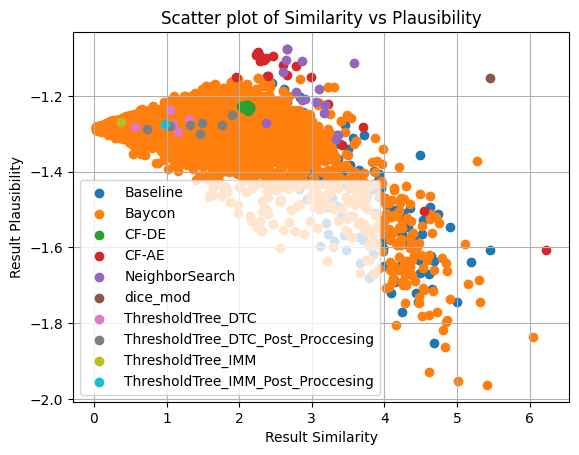

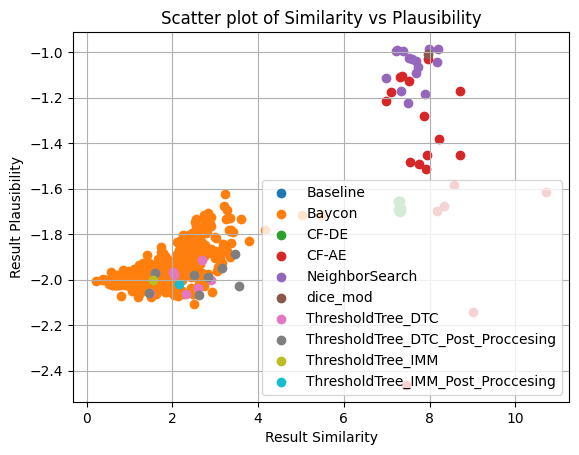

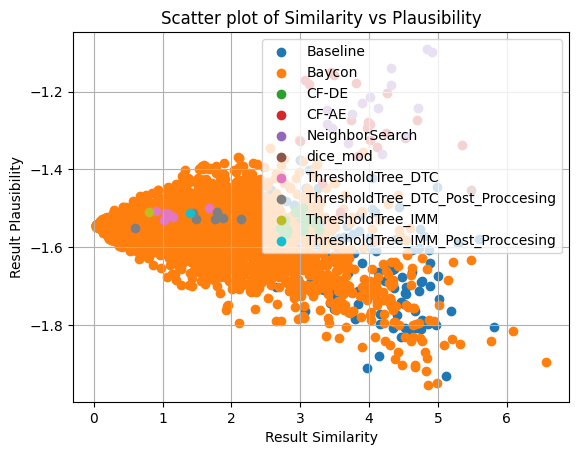

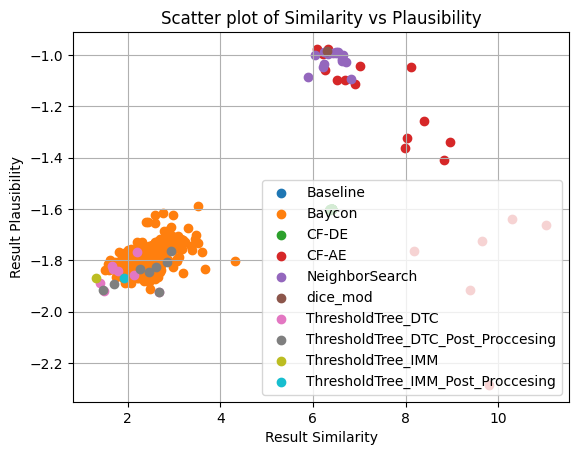

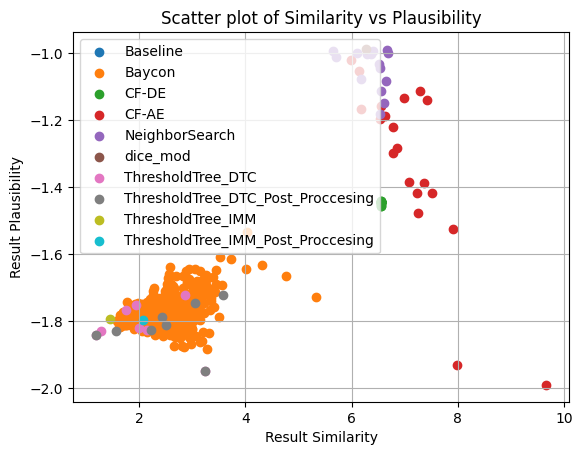

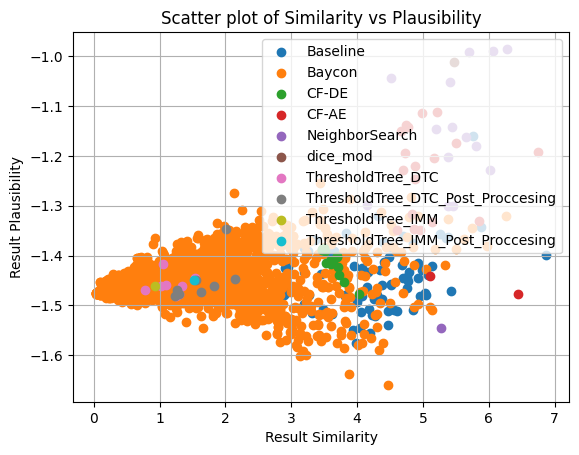

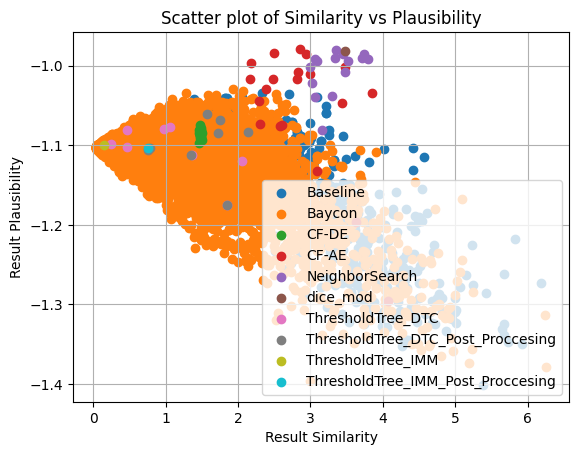

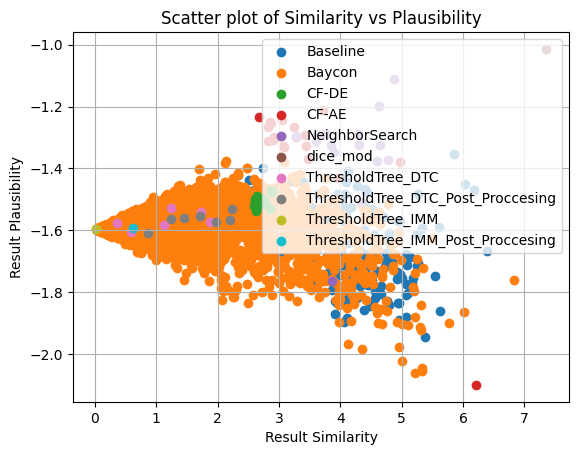

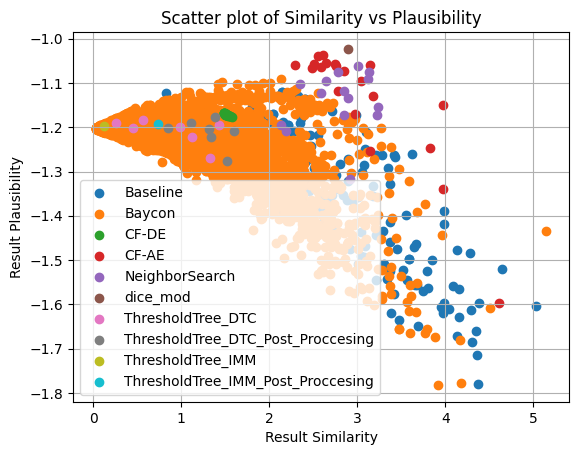

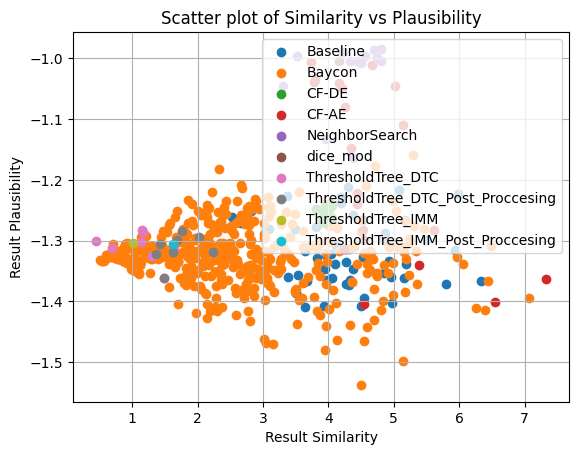

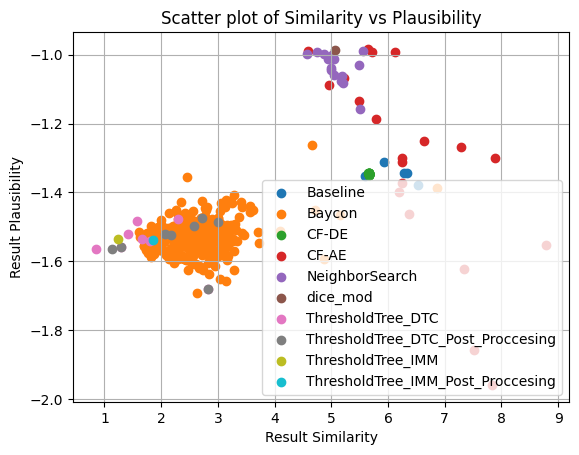

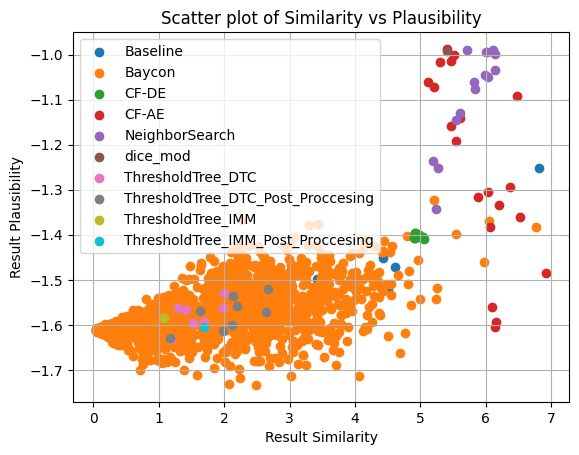

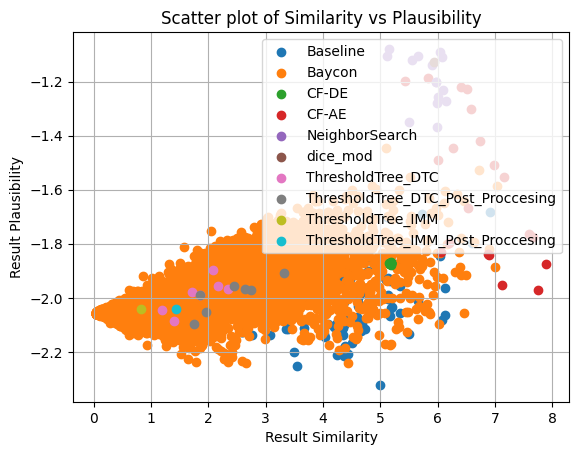

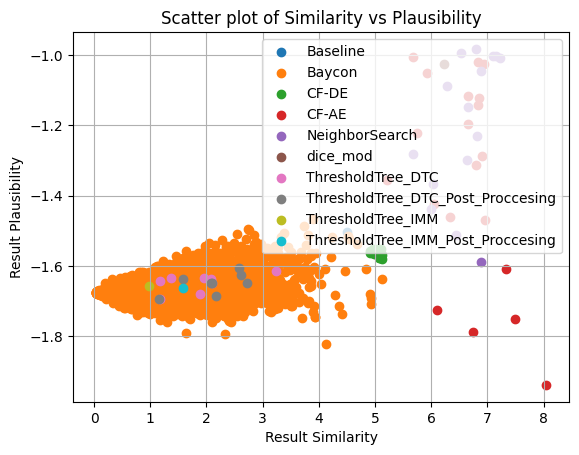

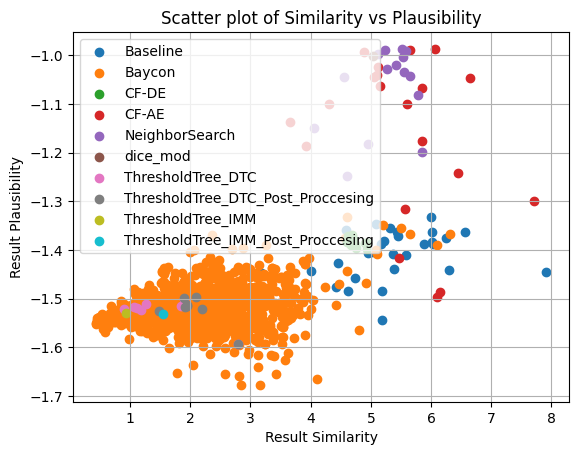

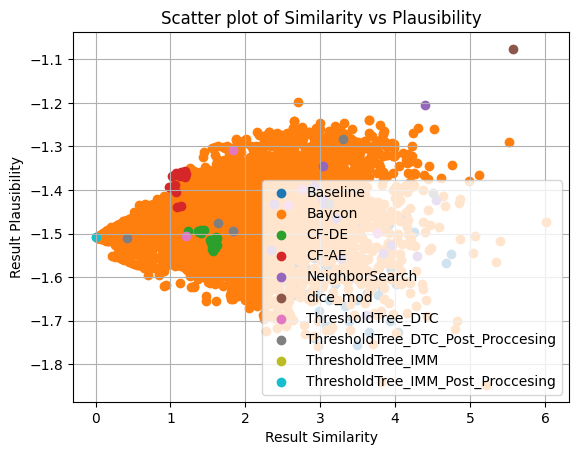

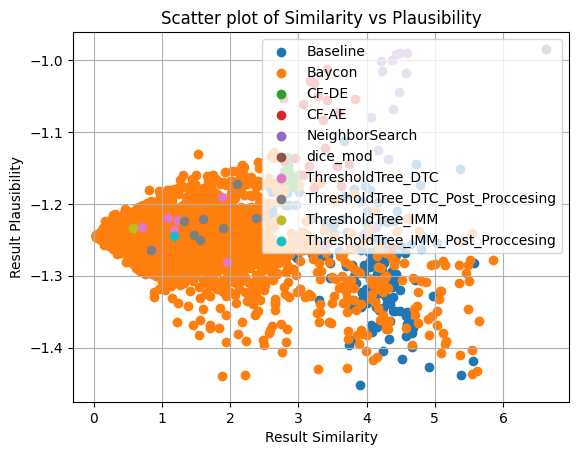

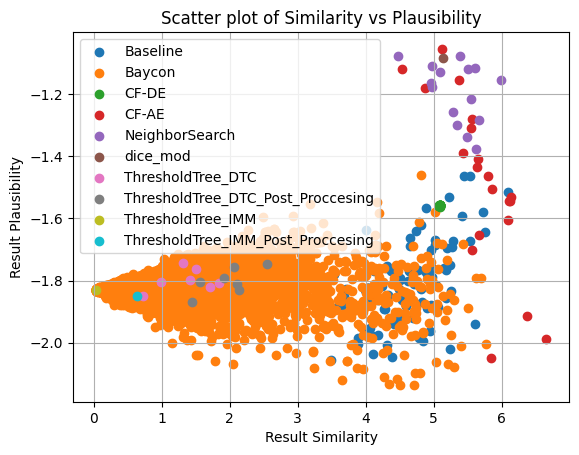

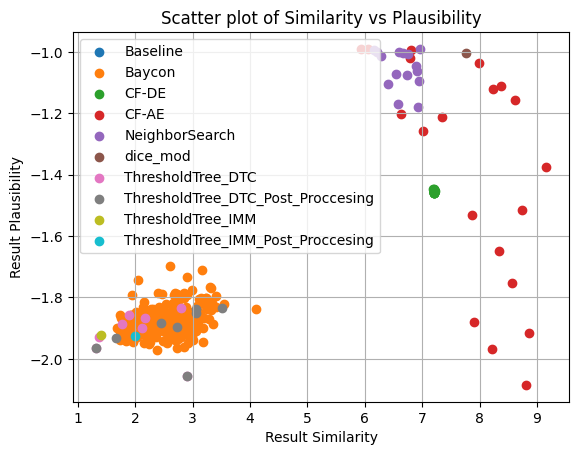

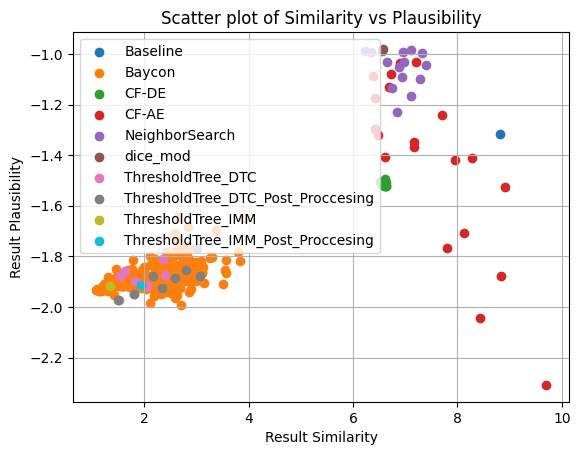

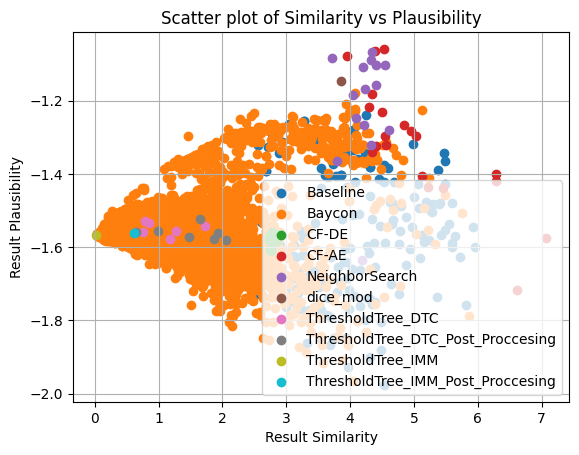

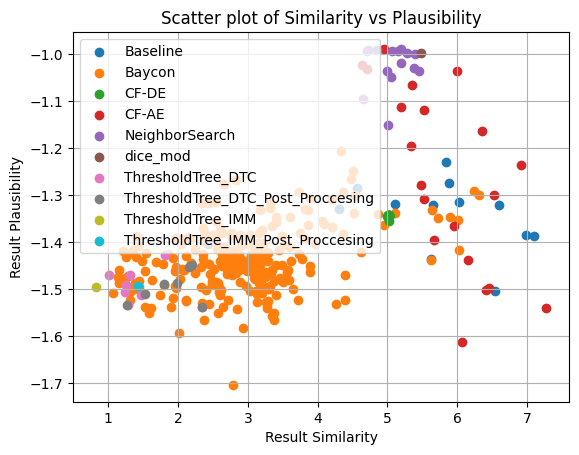

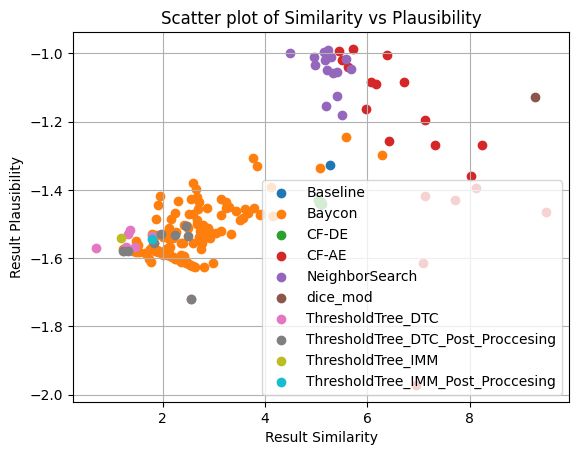

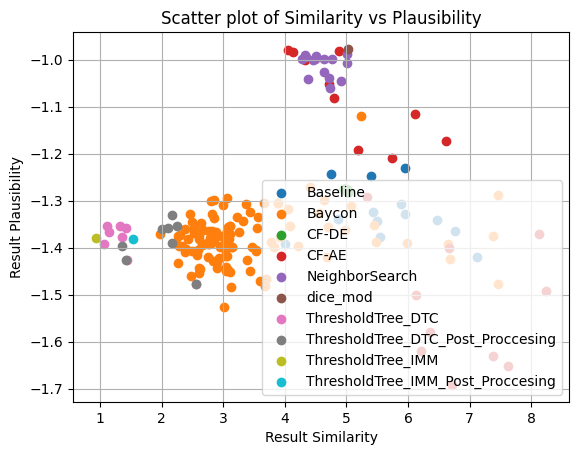

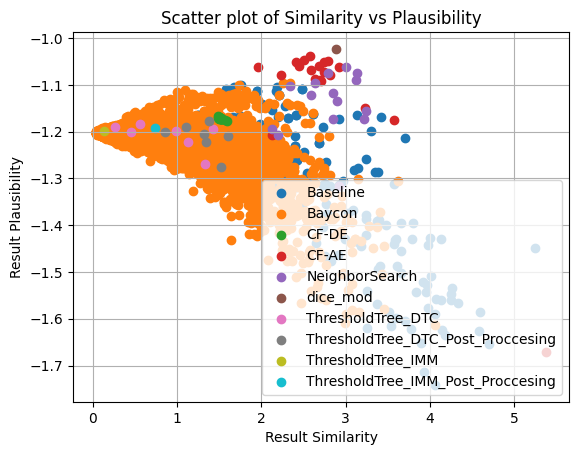

In [39]:
print(n)
for i in range(cf_amount):
    plot(0,2, methodNames, results, returnNames(), plt_index=i)

<Axes: >

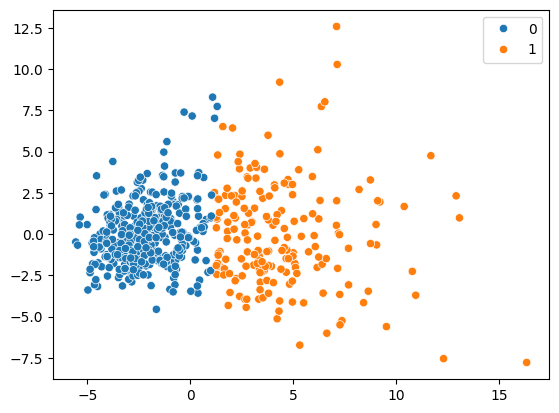

In [40]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

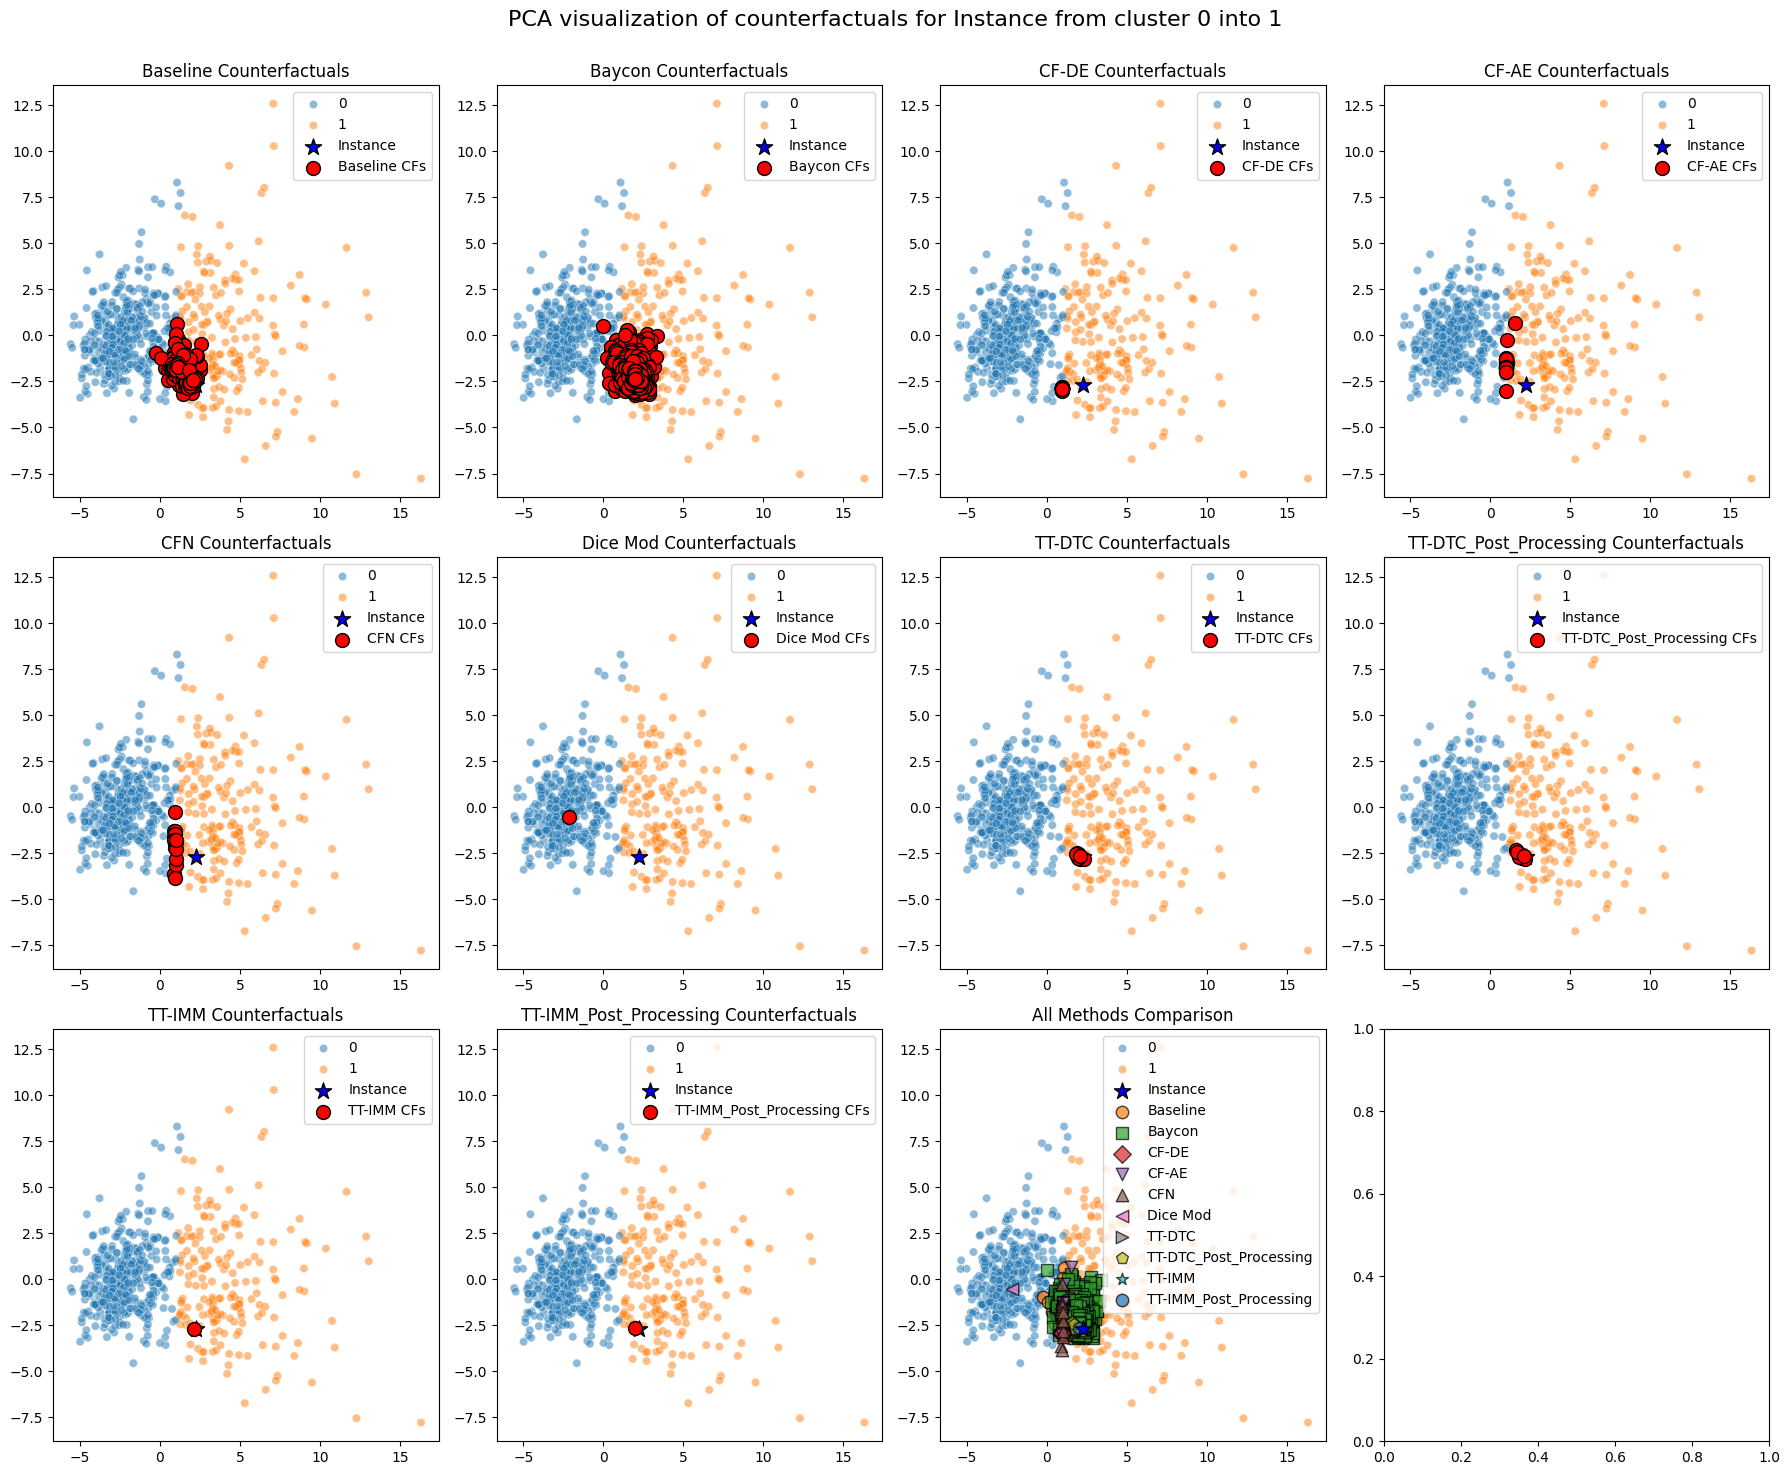

In [44]:
cf_n = 0

fig, axs = plt.subplots(3, 4, figsize=(18, 15))
axs = axs.flatten()

cffDict = None
with open('testdata/data25Breast.pickle', 'rb') as handle:
    cffDict = pickle.load(handle)


# Transform data with PCA
baseline_embed = pca.transform(cffDict[0]['counterfactuals'][cf_n].cf)
baycon_embed = pca.transform(cffDict[1]['counterfactuals'][cf_n].cf)
cfde_embed = pca.transform(np.array(cffDict[2]['counterfactuals'][cf_n].cf))
cfae_embed = pca.transform(np.array(cffDict[3]['counterfactuals'][cf_n].cf))
cfn_embed = pca.transform(np.array(cffDict[4]['counterfactuals'][cf_n].cf))
dice_embed = pca.transform(cffDict[5]['counterfactuals'][cf_n].cf)
tt_dtc_embed = pca.transform(cffDict[6]['counterfactuals'][cf_n].cf)
tt_dtc_prime_embed = pca.transform(cffDict[7]['counterfactuals'][cf_n].cf)
tt_imm_embed = pca.transform(cffDict[8]['counterfactuals'][cf_n].cf)
tt_imm_prime_embed = pca.transform(cffDict[9]['counterfactuals'][cf_n].cf)
instance_embedded = pca.transform(X[[cffDict[0]['counterfactuals'][cf_n].instance]])

ins_c = cffDict[0]['counterfactuals'][cf_n].instance_label
target_c = cffDict[0]['counterfactuals'][cf_n].target

# Plot each method's counterfactuals
methods = [
    ('Baseline', baseline_embed),
    ('Baycon', baycon_embed),
    ('CF-DE', cfde_embed),
    ('CF-AE', cfae_embed),
    ('CFN', cfn_embed),
    ('Dice Mod', dice_embed),
    ('TT-DTC', tt_dtc_embed),
    ('TT-DTC_Post_Processing', tt_dtc_prime_embed),
    ('TT-IMM', tt_imm_embed),
    ('TT-IMM_Post_Processing', tt_imm_prime_embed)
]

# Base scatterplot of the data
for i in range(len(methods)):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

for i, (name, embed) in enumerate(methods):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods)])
axs[len(methods)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*', 'o']
for i, (name, embed) in enumerate(methods):
    axs[len(methods)].scatter(embed[:, 0], embed[:, 1], marker=markers[i], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods)].set_title("All Methods Comparison")
axs[len(methods)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


## Running time

In [ ]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, model=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 395 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (772) CFs (0)
Re-training surrogate model with data size: 772
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (5) Unique overall (5)
Generated random instances: (3720)
Predicted top: 20 Counterfactuals: 1
Found new best [-1.22360473 -0.49092937 -0.09140243 -0.13022891  0.84041121 -0.9614272
  1.16553554  1.02245633  0.06514743 -0.06283955  1.64460656 -0.42466606
  1.31626659 -0.60872304 -0.55668221 -0.71248761 -0.68216318 -1.26715141
 -0.40589132 -0.88923254 -0.27939364 -0.0549147  -1.05103977 -0.05901454
 -1.12958929 -0.83439294 -0.38227819  1.39220769 -0.61112587  1.32577023], with fitness score 0.4160 (X 0.83191 Y 1.0 F 0.5), oversampling
Known alternatives: 792
Best instance score 0.4160 (X 0.83191 Y 1

KeyboardInterrupt: 